# 🌡️ Temperature — Anomaly Detection & Forecasting

This notebook loads the raw temperature data from `temp_hum.csv`, performs EDA, trains an **Isolation Forest** for anomaly detection and a **Linear Regression** model for forecasting, then exports the models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib, os, warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
print('Libraries loaded ✅')

Libraries loaded ✅


## 1 — Load & Clean Data

In [2]:
# Load raw CSV (no header — custom format: date, time, T=val, H=val)
raw = pd.read_csv('../raw/temp_hum.csv', header=None, names=['date', 'time', 'temp_raw', 'hum_raw'])
print(f'Raw rows: {len(raw)}')
raw.head()

Raw rows: 336


,date,time,temp_raw,hum_raw
0,3/14/19,19:33:07,T=22.0,H=20.0
1,3/14/19,19:38:10,T=22.0,H=20.0
2,3/14/19,19:43:11,T=22.0,H=26.0
3,3/14/19,19:48:14,T=22.0,H=26.0
4,3/14/19,19:53:15,T=22.0,H=20.0


In [3]:
# Filter out error rows
raw = raw[raw['temp_raw'].str.startswith('T=', na=False)].copy()
print(f'Valid rows after removing errors: {len(raw)}')

# Parse values
raw['temperature'] = raw['temp_raw'].str.replace('T=', '', regex=False).astype(float)
raw['humidity'] = raw['hum_raw'].str.replace('H=', '', regex=False).astype(float)

# Build datetime index
raw['datetime'] = pd.to_datetime(raw['date'] + ' ' + raw['time'], format='%m/%d/%y %H:%M:%S')
df = raw[['datetime', 'temperature', 'humidity']].set_index('datetime').sort_index()

# Remove extreme outlier (e.g. T=9 with H=140)
df = df[(df['temperature'] > 10) & (df['humidity'] < 100)]
print(f'Clean rows: {len(df)}')
df.describe()

Valid rows after removing errors: 320
Clean rows: 319


,temperature,humidity
count,319.000000,319.000000
mean,21.391850,21.495298
std,5.007547,3.782508
min,15.000000,12.000000
25%,18.000000,20.000000
50%,20.000000,21.000000
75%,23.000000,23.000000
max,37.000000,37.000000


## 2 — Exploratory Data Analysis

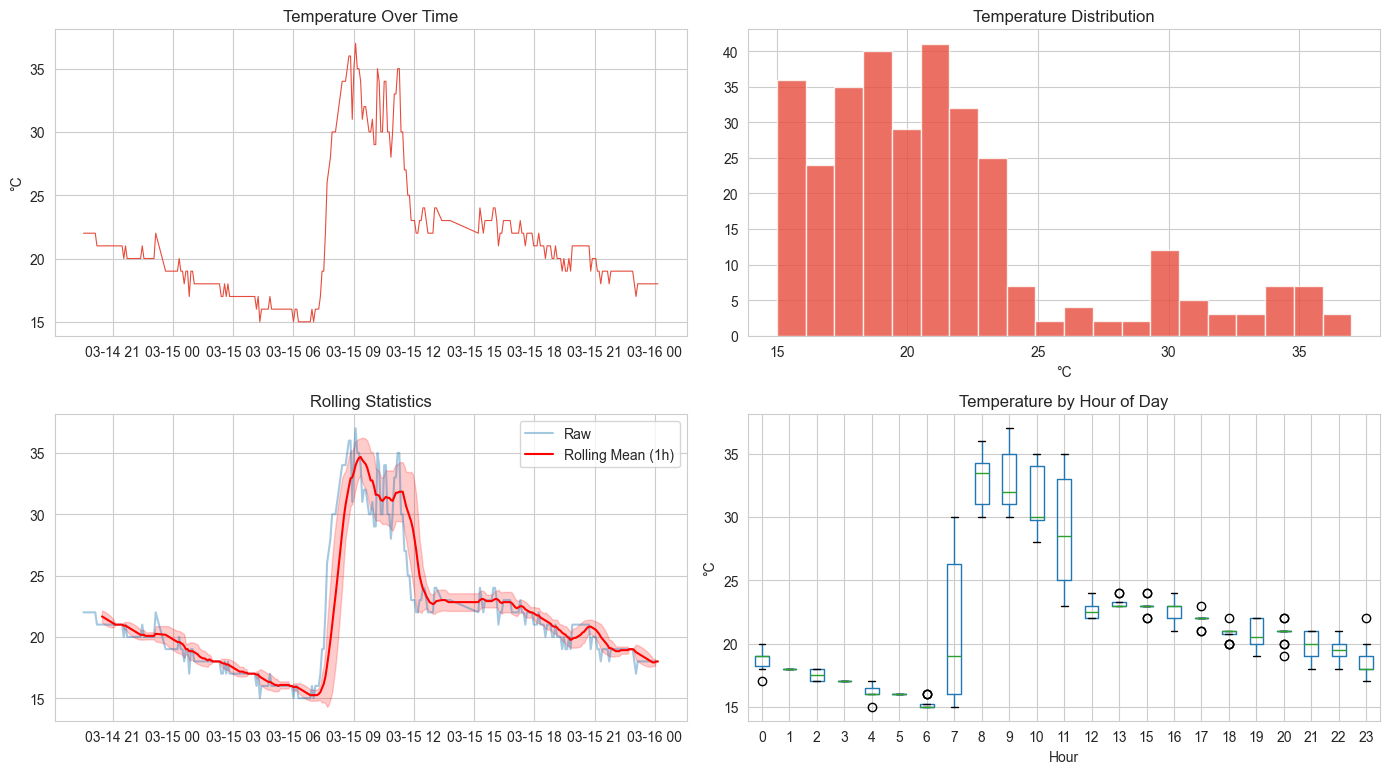

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Time-series
axes[0, 0].plot(df.index, df['temperature'], color='#e74c3c', linewidth=0.8)
axes[0, 0].set_title('Temperature Over Time')
axes[0, 0].set_ylabel('°C')

# Distribution
axes[0, 1].hist(df['temperature'], bins=20, color='#e74c3c', edgecolor='white', alpha=0.8)
axes[0, 1].set_title('Temperature Distribution')
axes[0, 1].set_xlabel('°C')

# Rolling stats
rolling = df['temperature'].rolling(window=12)
axes[1, 0].plot(df.index, df['temperature'], alpha=0.4, label='Raw')
axes[1, 0].plot(df.index, rolling.mean(), color='red', label='Rolling Mean (1h)')
axes[1, 0].fill_between(df.index, rolling.mean() - rolling.std(), rolling.mean() + rolling.std(), alpha=0.2, color='red')
axes[1, 0].set_title('Rolling Statistics')
axes[1, 0].legend()

# Boxplot by hour
df['hour'] = df.index.hour
df.boxplot(column='temperature', by='hour', ax=axes[1, 1])
axes[1, 1].set_title('Temperature by Hour of Day')
axes[1, 1].set_xlabel('Hour')
axes[1, 1].set_ylabel('°C')
plt.suptitle('')

plt.tight_layout()
plt.show()

## 3 — Feature Engineering

In [5]:
df['hour'] = df.index.hour
df['minute'] = df.index.minute
df['temp_rolling_mean'] = df['temperature'].rolling(window=6, min_periods=1).mean()
df['temp_rolling_std'] = df['temperature'].rolling(window=6, min_periods=1).std().fillna(0)
df['temp_lag_1'] = df['temperature'].shift(1).bfill()
df['temp_lag_3'] = df['temperature'].shift(3).bfill()

features = ['hour', 'minute', 'temp_rolling_mean', 'temp_rolling_std', 'temp_lag_1', 'temp_lag_3']
df.dropna(inplace=True)
print(f'Feature-engineered rows: {len(df)}')
df[features].head()

Feature-engineered rows: 319


,hour,minute,temp_rolling_mean,temp_rolling_std,temp_lag_1,temp_lag_3
datetime,,,,,,
2019-03-14 19:33:07,19,33,22.0,0.0,22.0,22.0
2019-03-14 19:38:10,19,38,22.0,0.0,22.0,22.0
2019-03-14 19:43:11,19,43,22.0,0.0,22.0,22.0
2019-03-14 19:48:14,19,48,22.0,0.0,22.0,22.0
2019-03-14 19:53:15,19,53,22.0,0.0,22.0,22.0


## 4 — Anomaly Detection (Isolation Forest)

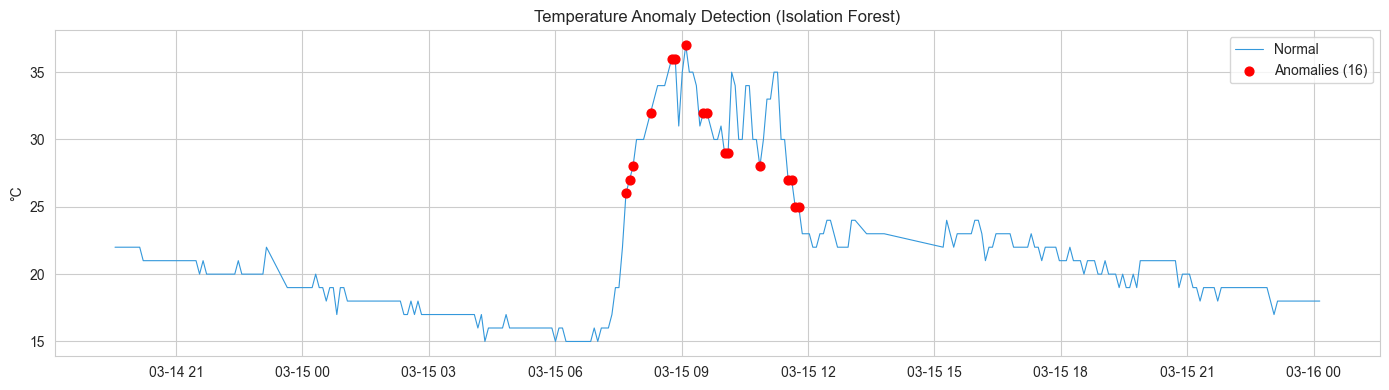

Anomalies detected: 16 / 319 (5.0%)


In [6]:
iso_model = IsolationForest(contamination=0.05, random_state=42, n_estimators=100)
df['anomaly'] = iso_model.fit_predict(df[['temperature']])
anomalies = df[df['anomaly'] == -1]

plt.figure(figsize=(14, 4))
plt.plot(df.index, df['temperature'], label='Normal', color='#3498db', linewidth=0.8)
plt.scatter(anomalies.index, anomalies['temperature'], color='red', s=40, zorder=5, label=f'Anomalies ({len(anomalies)})')
plt.title('Temperature Anomaly Detection (Isolation Forest)')
plt.ylabel('°C')
plt.legend()
plt.tight_layout()
plt.show()

print(f'Anomalies detected: {len(anomalies)} / {len(df)} ({100*len(anomalies)/len(df):.1f}%)')

## 5 — Temperature Forecasting (Linear Regression)

MAE:  0.38 °C
RMSE: 0.55 °C


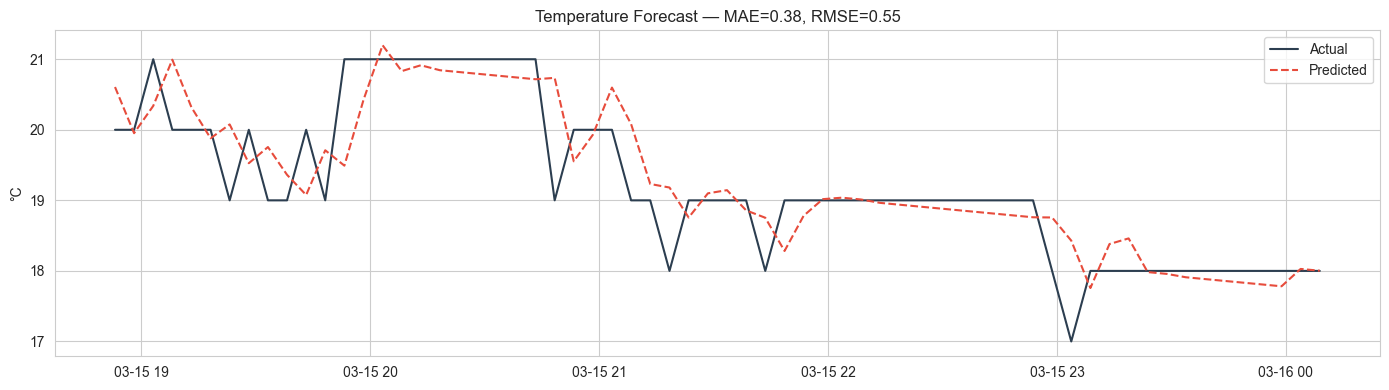

In [7]:
X = df[features]
y = df['temperature']

split = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

reg_model = LinearRegression()
reg_model.fit(X_train, y_train)
y_pred = reg_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'MAE:  {mae:.2f} °C')
print(f'RMSE: {rmse:.2f} °C')

plt.figure(figsize=(14, 4))
plt.plot(y_test.index, y_test.values, label='Actual', color='#2c3e50')
plt.plot(y_test.index, y_pred, label='Predicted', color='#e74c3c', linestyle='--')
plt.title(f'Temperature Forecast — MAE={mae:.2f}, RMSE={rmse:.2f}')
plt.ylabel('°C')
plt.legend()
plt.tight_layout()
plt.show()

## 6 — Export Models

In [8]:
os.makedirs('../models', exist_ok=True)

joblib.dump({
    'isolation_forest': iso_model,
    'linear_regression': reg_model,
    'features': features,
    'metrics': {'mae': mae, 'rmse': rmse}
}, '../models/temperature_model.pkl')

print('✅ Model exported to models/temperature_model.pkl')

✅ Model exported to models/temperature_model.pkl
